In [2]:
random_state = 42 # notebook consistency

from typing import List
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
import os

from tqdm import tqdm
import time

from scipy.cluster.hierarchy import linkage, fcluster

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from umap import UMAP
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import silhouette_score

from sklearn.metrics import adjusted_rand_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

import warnings

warnings.filterwarnings(
    "ignore",
    message="Graph is not fully connected",
    category=UserWarning,
    module="sklearn.cluster.SpectralClustering"
)

## Load data
cwd = os.getcwd()
os.chdir('..')
from scripts.consensus_matrix import *
from scripts.utils import *
df = pd.read_csv('BRCA_data.csv')

os.chdir(cwd)

sample_name = df.iloc[:,0].copy()    # sample index
X = df.iloc[:,1:354].copy()          # X : gene expression features
y = df.iloc[:,354:].copy()           # y : clinical labels

## Fit UMAP
umap_model = UMAP(
    n_neighbors=10,
    n_components=2,
    min_dist=0.1,
    metric="euclidean",
    random_state=random_state,
    n_jobs=1
)
X_umap = make_pipeline(umap_model).fit_transform(X)

## Silhouette Score

In [3]:
## Specify
verbose_bool = False

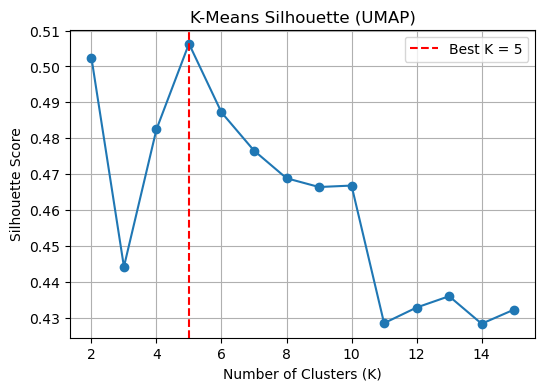

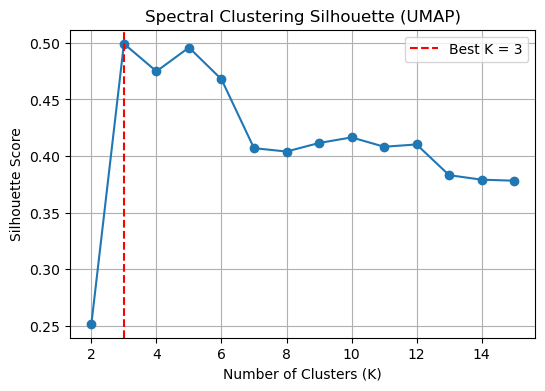

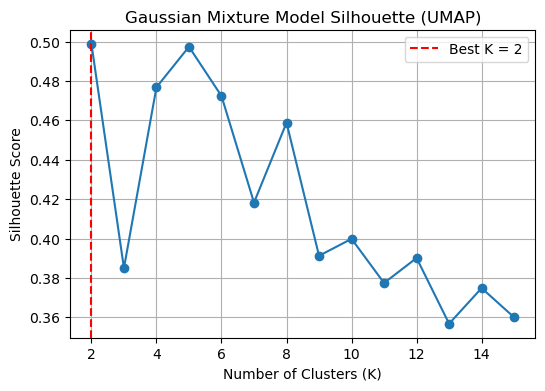

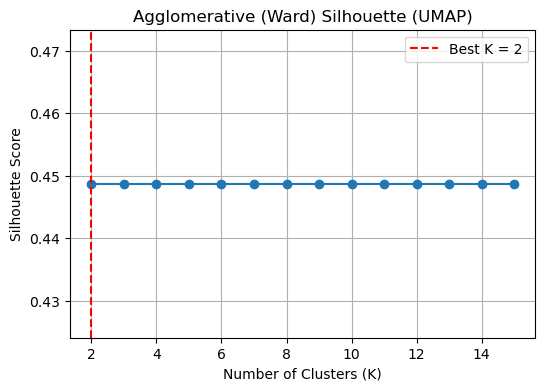

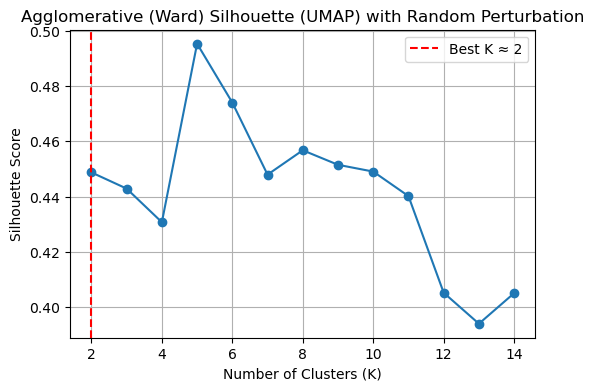

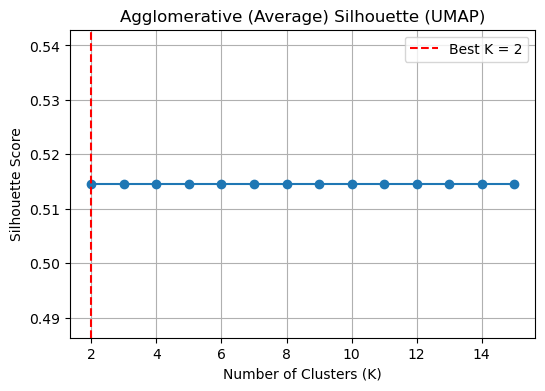

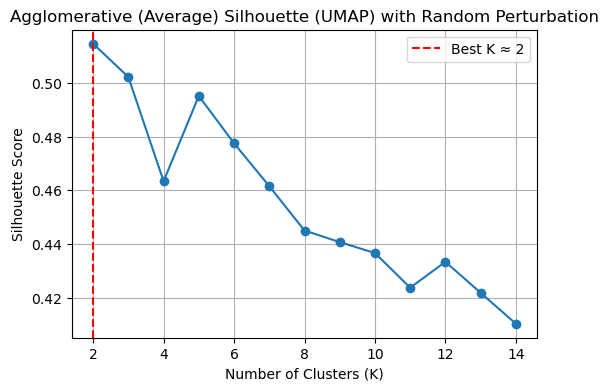

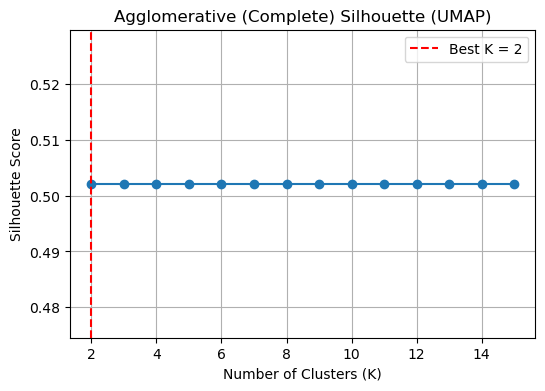

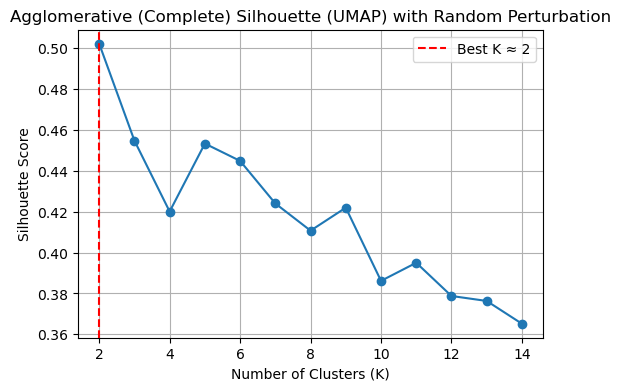

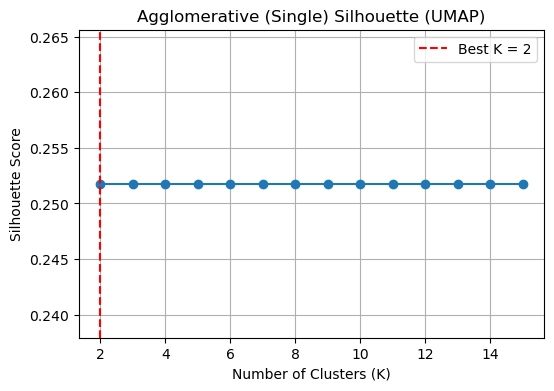

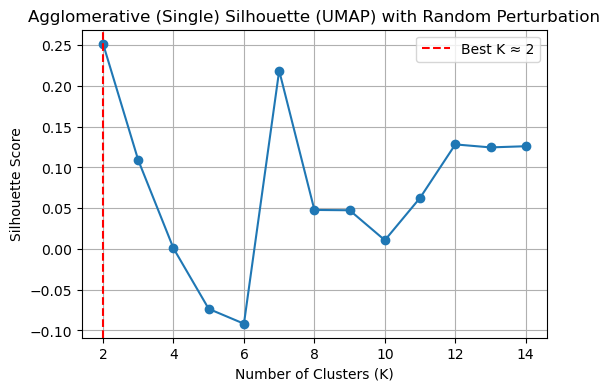

In [4]:
## Kmeans
best_k_kmeans, scores_kmeans = silhouette_analysis(
    X_umap,
    method=KMeans,
    params=dict(n_init=10),
    random_state=random_state,
    verbose=verbose_bool
)
plot_silhouette(scores_kmeans, best_k_kmeans, title="K-Means Silhouette (UMAP)")

## Spectral
best_k_spec, scores_spec = silhouette_analysis(
    X_umap,
    method=SpectralClustering,
    params=dict(affinity="nearest_neighbors"),
    random_state=random_state,
    verbose=verbose_bool
)
plot_silhouette(
    scores_spec,
    best_k_spec,
    title="Spectral Clustering Silhouette (UMAP)"
)

## GMM
best_k_gmm, scores_gmm = silhouette_analysis(
    X_umap,
    method=GaussianMixture,
    params=dict(covariance_type="full"),
    random_state=random_state,
    verbose=verbose_bool
)
plot_silhouette(
    scores_gmm,
    best_k_gmm,
    title="Gaussian Mixture Model Silhouette (UMAP)"
)

## Hierarchial

for link in ["ward", "average", "complete", "single"]:
    best_k, scores = (
        silhouette_analysis(
            X_umap, 
            method=AgglomerativeClustering,
            params=dict(linkage=link),
            random_state=random_state,
            verbose=verbose_bool
        )
    )
    plot_silhouette(scores, best_k, title=f"Agglomerative ({link.capitalize()}) Silhouette (UMAP)")
    agglomerative_jitter_silhouette_scores(X_umap, random_state, link)

Best cut height t* = 0.1463 | silhouette = 0.2978 | K = 209


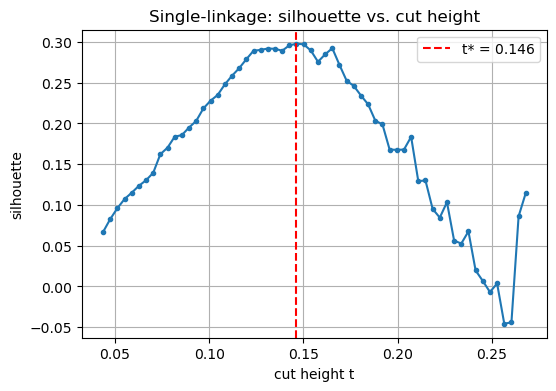

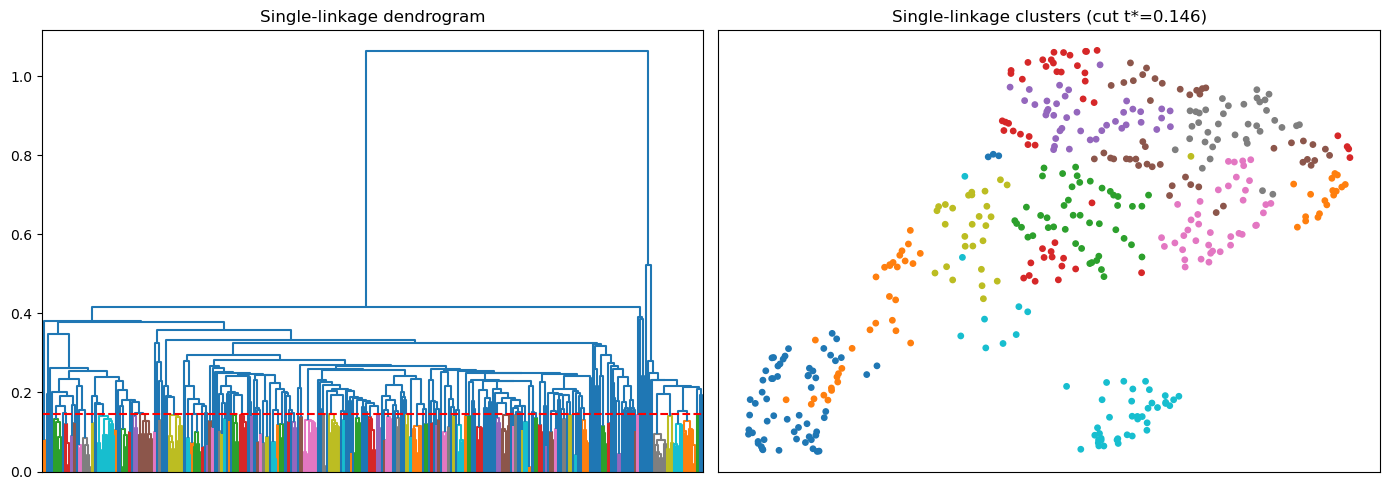

In [5]:
# --- run it on UMAP embedding ---
Z, ts, sc, best = single_linkage_best_cut(X_umap, metric="euclidean")
best_t, best_s, best_labels = best
print(f"Best cut height t* = {best_t:.4f} | silhouette = {best_s:.4f} | K = {len(np.unique(best_labels))}")

# plot silhouette over cut heights
plt.figure(figsize=(6,4))
plt.plot(ts, sc, marker='o', ms=3)
plt.axvline(best_t, color='red', ls='--', label=f"t* = {best_t:.3f}")
plt.title("Single-linkage: silhouette vs. cut height")
plt.xlabel("cut height t")
plt.ylabel("silhouette")
plt.grid(True); plt.legend(); plt.show()

# dendrogram + scatter with chosen cut
from scipy.cluster.hierarchy import dendrogram
fig, ax = plt.subplots(1,2, figsize=(14,5))
dendrogram(Z, no_labels=True, color_threshold=best_t, ax=ax[0])
ax[0].axhline(best_t, color='red', ls='--'); ax[0].set_title("Single-linkage dendrogram")

ax[1].scatter(X_umap[:,0], X_umap[:,1], c=best_labels, cmap="tab10", s=15)
ax[1].set_title(f"Single-linkage clusters (cut t*={best_t:.3f})"); ax[1].set_xticks([]); ax[1].set_yticks([])
plt.tight_layout(); plt.show()


In [6]:
# DBSCAN Silhouette score
res = dbscan_silhouette(X_umap, eps=0.35, min_samples=5)
print(f"silhouette={res['score']:.4f} | clusters={res['n_clusters']} | noise={res['n_noise']}")

silhouette=0.3881 | clusters=5 | noise=20
